# Objective
Utlizing an ensemble of ML classifiers to predict if a customer responded to a banks advertising or insurance rate offers.

# Features
* customer_id - an anonymous id unique to a given customer
* Balance : - Current + Savings Account Balance
* PreviousCampaignResult - Last Campaign Results
* Product1...Product6 - List of different products owned by the customer
* Transaction1...Transaction9 - Last 9 transactions made by the customer
* External Accounts 1...External Accounts 7 - * External accounts held by the customer, including bills
* Activity Indicator - Number of activities done the customer, including telebanking, going to the bank
* Regular Interaction Indicator - How frequent the customer is interacting with the bank (Rating Scale)
* CompetitiveRate1 ... CompetitiveRate7 - Interest rates offered to the customer
* RateBefore - Interest rates on the products, customer have before the competitive rates being offered
* ReferenceRate -Interest rates on the products, the customer have after the negotiations made to the competitive rates being offered

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

# Check if data loaded

In [3]:
df_test.head()

,Customer_id,Balance,PreviousCampaignResult,Product1,Product2,Product3,Product4,Product5,Product6,Transaction1,...,RegularInteractionIndicator,CompetitiveRate1,CompetitiveRate2,CompetitiveRate3,CompetitiveRate4,CompetitiveRate5,CompetitiveRate6,CompetitiveRate7,RateBefore,ReferenceRate
0,CTSP063999,13341.55,0,0,0,0,0,0,0,0.0,...,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
1,CTSP064000,18649.81,0,1,0,0,0,0,0,0.0,...,0,1.025,1.925,1.125,2.375,1.175,1.425,1.475,1.425,1.125
2,CTSP064001,28311.30,0,1,0,0,1,0,0,0.0,...,1,1.425,2.375,1.425,1.675,2.375,1.675,1.575,1.675,1.375
3,CTSP064002,18066.61,0,1,0,0,0,0,0,0.0,...,0,1.025,1.925,1.125,2.375,1.175,1.425,1.475,1.425,1.125
4,CTSP064003,10512.30,0,0,0,0,0,0,0,0.0,...,1,1.425,2.375,1.425,1.675,2.375,1.675,1.575,1.675,1.375


In [4]:
df_train.head()

,Customer_id,Target,Balance,PreviousCampaignResult,Product1,Product2,Product3,Product4,Product5,Product6,...,RegularInteractionIndicator,CompetitiveRate1,CompetitiveRate2,CompetitiveRate3,CompetitiveRate4,CompetitiveRate5,CompetitiveRate6,CompetitiveRate7,RateBefore,ReferenceRate
0,CTSP000001,0,43824.59,0,0,0,0,0,0,0,...,0,1.025,1.925,1.125,2.375,1.175,1.425,1.475,1.425,1.125
1,CTSP000002,1,11256.21,0,0,0,0,0,0,0,...,3,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
2,CTSP000003,1,18795.11,0,1,1,0,0,0,0,...,0,1.425,2.375,1.425,1.675,2.375,1.675,1.575,1.675,1.375
3,CTSP000004,0,22274.72,0,0,0,0,0,0,0,...,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
4,CTSP000005,0,47923.40,0,1,0,0,0,0,0,...,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375


# Useful Functions for Inspecting

In [5]:
# a function that creates a dictionary of dataframes 
# where each key is the df's features and the values are the features respective df
def feature_dict(df):
    feature_dict = {}

    for i in df.columns:
        # create a df for each feature by subsetting df containing a certain literal string
        feature_dict[i] = df[df.columns[df.columns.str.contains(f'{i}', regex = False)]]

    return feature_dict

In [6]:
# create feature dict for train dataset
feature_dict = feature_dict(df_train)

In [7]:
# takes feature name in string form
def response_count(feature_name):
    # need to include axis = 1 to avoid autofill of NaN for indices that do not align
    df = pd.concat([value for (key, value) in feature_dict.items() if f'{feature_name}' in key], axis = 1)

    dict_1 = {}   # create emtpy dictionary

    # count the number of 0 and 1 for each product
    # save results in a dict 
    for (k,v) in df.items():
        dict_1[f'{k}'] = df[f'{k}'].value_counts()

        # convert dict to dataframe
        df_count = pd.DataFrame.from_dict(data = dict_1)

    return df_count

In [8]:
def single_count_plotter (feature_name):
    total = len(feature_dict[feature_name])

    plt.figure(figsize = (10,6))

    count_plot = sns.countplot(x = feature_name, data = feature_dict[feature_name])

    for i in count_plot.patches:                    # get plot axis locations
        height = i.get_height()
        count_plot.text(
            i.get_x() + i.get_width() / 2,            # location of text
            height + 3,
            '{:.2f}%'.format(height / total * 100),   # proportion of total target sample size (2 sigfigs)
            ha = 'center',                            # center alignment
            fontsize = 10
        )

In [9]:
def multi_count_plotter (df, feature_name):
    # number of columns for subplots
    ncols = 2              

    # n x 2 subplots
    fig, ax = plt.subplots(
        len(df.columns) // ncols, 
        ncols, 
        figsize = (20,25)
    )      

    total = df.sum()[0]   # used for getting proportions
    i = 1                 # indice for iterating through repetitive feature names

    axis_label_size = 15
    title_size = 25

    for axis in ax.flat:

        # make countplots for each product and place plot on the subplot axis created 
        plot = sns.countplot(data = feature_dict[f'{feature_name}{i}'], x = f'{feature_name}{i}', ax = axis)

        for n in plot.patches:                    # get plot info
            height = n.get_height()
            plot.text(
              n.get_x() + n.get_width() / 2,            # location of text
              height + 3,
              '{:.2f}%'.format(height / total * 100),   # proportion of total target sample size (2 sigfigs)
              ha = 'center',                            # center alignment
              fontsize = 20
            )

        plot.set_title(f'{feature_name}{i} Count', fontsize = title_size)
        plot.set_ylabel('Count', fontsize = axis_label_size)

        i += 1

# Inspect data

## Inspect Training Data
* 63999 rows
* 37 features
* no null/missing values

In [10]:
df_train.shape

(63999, 37)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63999 entries, 0 to 63998
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_id                  63999 non-null  object 
 1   Target                       63999 non-null  int64  
 2   Balance                      63999 non-null  float64
 3   PreviousCampaignResult       63999 non-null  int64  
 4   Product1                     63999 non-null  int64  
 5   Product2                     63999 non-null  int64  
 6   Product3                     63999 non-null  int64  
 7   Product4                     63999 non-null  int64  
 8   Product5                     63999 non-null  int64  
 9   Product6                     63999 non-null  int64  
 10  Transaction1                 63999 non-null  float64
 11  Transaction2                 63999 non-null  float64
 12  Transaction3                 63999 non-null  float64
 13  Transaction4    

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_id                  1480 non-null   object 
 1   Balance                      1480 non-null   float64
 2   PreviousCampaignResult       1480 non-null   int64  
 3   Product1                     1480 non-null   int64  
 4   Product2                     1480 non-null   int64  
 5   Product3                     1480 non-null   int64  
 6   Product4                     1480 non-null   int64  
 7   Product5                     1480 non-null   int64  
 8   Product6                     1480 non-null   int64  
 9   Transaction1                 1480 non-null   float64
 10  Transaction2                 1480 non-null   float64
 11  Transaction3                 1480 non-null   float64
 12  Transaction4                 1480 non-null   float64
 13  Transaction5      

In [13]:
# check for null values - no null values
df_train.isnull().any()

Customer_id                    False
Target                         False
Balance                        False
PreviousCampaignResult         False
Product1                       False
Product2                       False
Product3                       False
Product4                       False
Product5                       False
Product6                       False
Transaction1                   False
Transaction2                   False
Transaction3                   False
Transaction4                   False
Transaction5                   False
Transaction6                   False
Transaction7                   False
Transaction8                   False
Transaction9                   False
ExternalAccount1               False
ExternalAccount2               False
ExternalAccount3               False
ExternalAccount4               False
ExternalAccount5               False
ExternalAccount6               False
ExternalAccount7               False
ActivityIndicator              False
R

## Train Data Histogram

array([[<AxesSubplot:title={'center':'Target'}>,
        <AxesSubplot:title={'center':'Balance'}>,
        <AxesSubplot:title={'center':'PreviousCampaignResult'}>,
        <AxesSubplot:title={'center':'Product1'}>,
        <AxesSubplot:title={'center':'Product2'}>,
        <AxesSubplot:title={'center':'Product3'}>],
       [<AxesSubplot:title={'center':'Product4'}>,
        <AxesSubplot:title={'center':'Product5'}>,
        <AxesSubplot:title={'center':'Product6'}>,
        <AxesSubplot:title={'center':'Transaction1'}>,
        <AxesSubplot:title={'center':'Transaction2'}>,
        <AxesSubplot:title={'center':'Transaction3'}>],
       [<AxesSubplot:title={'center':'Transaction4'}>,
        <AxesSubplot:title={'center':'Transaction5'}>,
        <AxesSubplot:title={'center':'Transaction6'}>,
        <AxesSubplot:title={'center':'Transaction7'}>,
        <AxesSubplot:title={'center':'Transaction8'}>,
        <AxesSubplot:title={'center':'Transaction9'}>],
       [<AxesSubplot:title={'cen

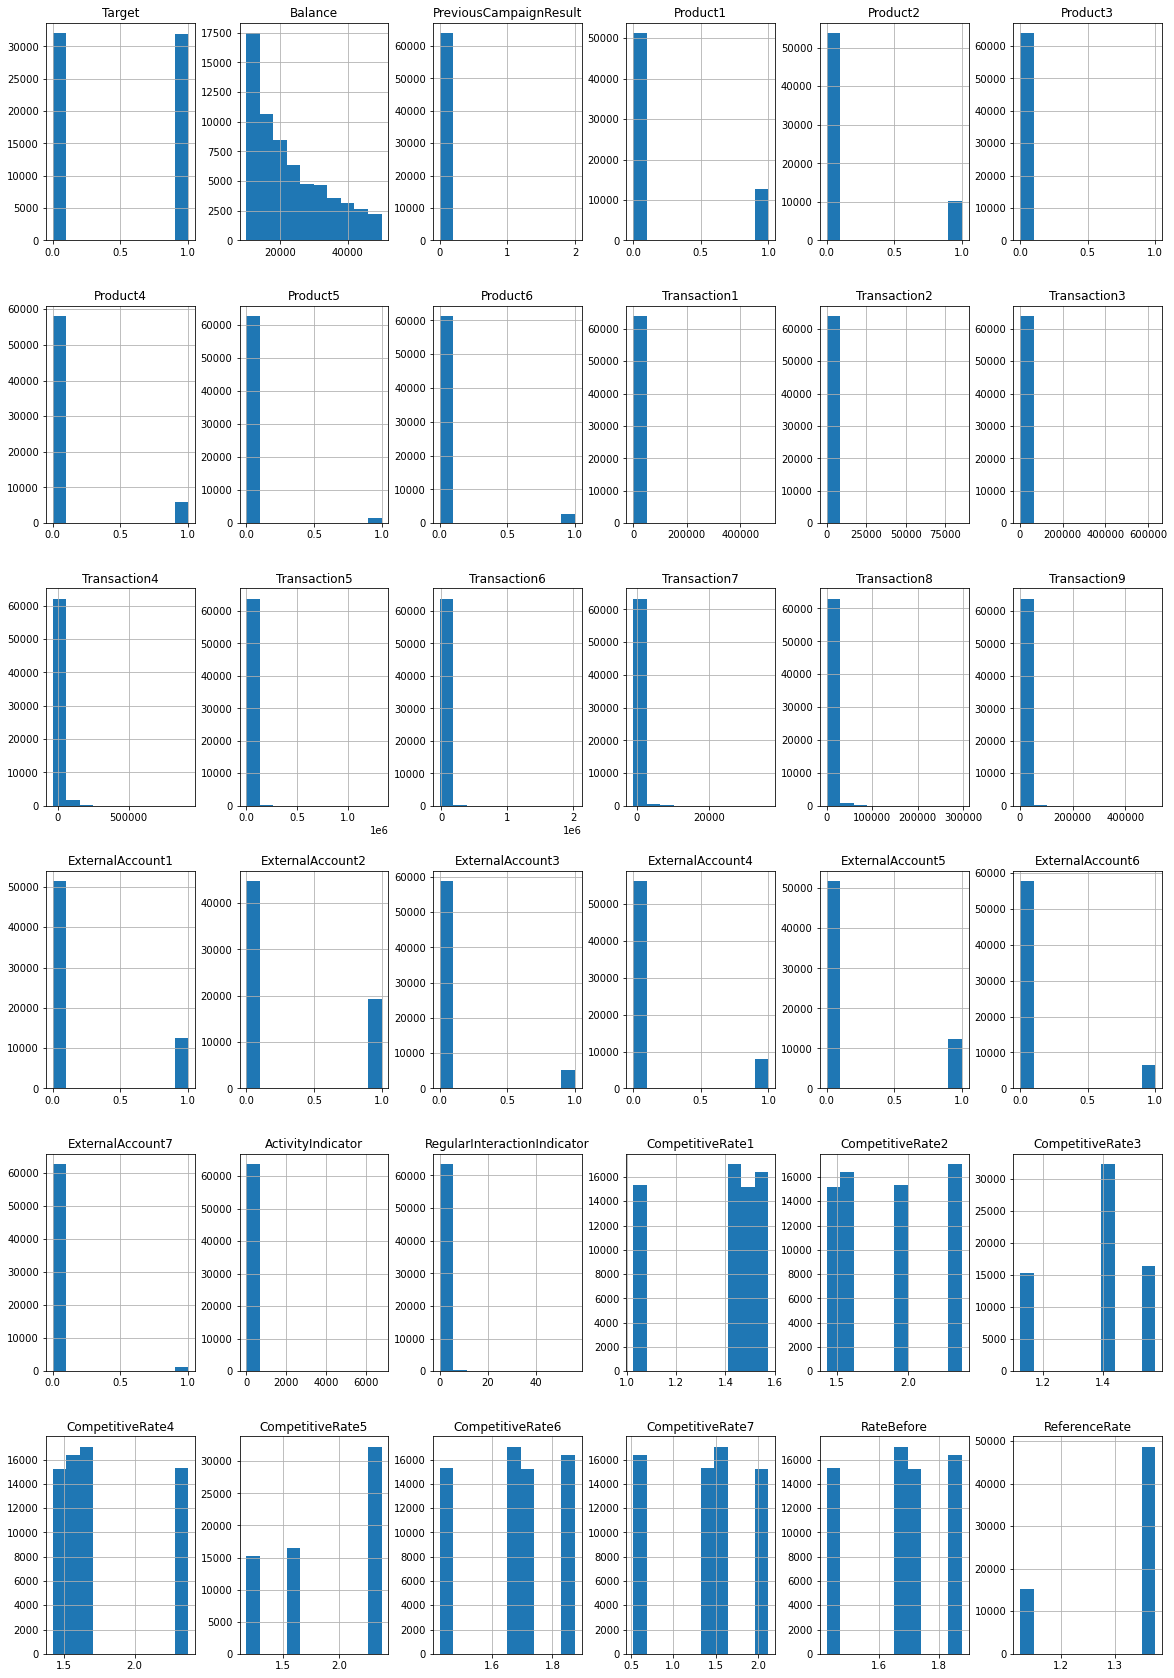

In [14]:
df_train.hist(figsize = (20,30))

## Inspect Target Feature
* almost a 50/50 chance of customers responding and not responding to campaign

In [15]:
feature_dict['Target'].value_counts()

Target
0         32014
1         31985
dtype: int64

## Target Distribution

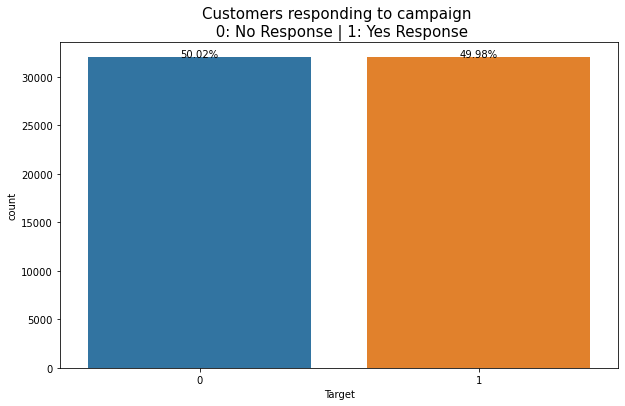

In [16]:
single_count_plotter('Target')

plt.title('Customers responding to campaign \n 0: No Response | 1: Yes Response', fontsize = 15)
plt.show()

## Inspect PreviousCampaignResult

In [17]:
df_train['PreviousCampaignResult'].value_counts()

0    63906
1       91
2        2
Name: PreviousCampaignResult, dtype: int64

## Customer Interaction w/ Bank "A"

* customer CTSP015232 has the most activity with the bank (6762)
* customer CTSP000001 has the least amount of activity with the bank

* compared to RegularInteractionIndicator (rating), customer CTSP030967 has the most frequent interaction with the bank thus with the highest rating

<AxesSubplot:>

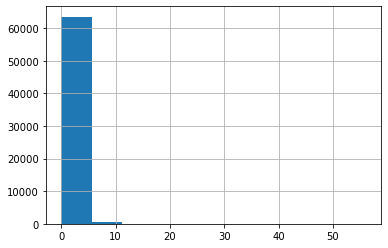

In [18]:
df_train['RegularInteractionIndicator'].hist()

In [19]:
pd.DataFrame(df_train.groupby('Customer_id')['ActivityIndicator'].sum())\
.reset_index()\
.sort_values(by = 'ActivityIndicator')

,Customer_id,ActivityIndicator
0,CTSP000001,0
31612,CTSP031613,0
31609,CTSP031610,0
31607,CTSP031608,0
31606,CTSP031607,0
...,...,...
19529,CTSP019530,3902
40570,CTSP040571,4422
18195,CTSP018196,4626
22019,CTSP022020,5474


In [20]:
pd.DataFrame(df_train.groupby('Customer_id')['RegularInteractionIndicator'].sum())\
.reset_index()\
.sort_values(by = 'RegularInteractionIndicator')

,Customer_id,RegularInteractionIndicator
0,CTSP000001,0
37944,CTSP037945,0
37945,CTSP037946,0
37946,CTSP037947,0
37947,CTSP037948,0
...,...,...
49782,CTSP049783,26
23507,CTSP023508,27
40182,CTSP040183,28
32666,CTSP032667,52


In [21]:
df1 = pd.DataFrame(df_train.groupby(['Customer_id', 'Target', 'RegularInteractionIndicator'])['ActivityIndicator'].sum())\
.reset_index()

df1[df1['Target'] == 1].sort_values(by = 'RegularInteractionIndicator', ascending = False)

,Customer_id,Target,RegularInteractionIndicator,ActivityIndicator
30966,CTSP030967,1,56,408
32666,CTSP032667,1,52,218
40182,CTSP040183,1,28,6
23507,CTSP023508,1,27,188
58851,CTSP058852,1,22,92
...,...,...,...,...
29809,CTSP029810,1,0,0
29807,CTSP029808,1,0,0
29804,CTSP029805,1,0,14
4851,CTSP004852,1,0,0


## Inspect Customer's Balance info
* a lot of customer's do not have large accounts with Bank "A"
* majority of the customers have accounts with less than $15000 in their accounts (chequing + savings)

array([[<AxesSubplot:title={'center':'Balance'}>]], dtype=object)

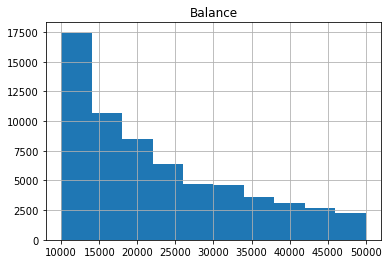

In [22]:
feature_dict['Balance'].hist()

In [23]:
feature_dict['Balance'].describe()

,Balance
count,63999.000000
mean,22697.014218
std,10819.489043
min,10000.000000
25%,13499.005000
50%,19982.570000
75%,30104.035000
max,50000.000000


## Summary Statistics Notes on interest rate offers:
* interest rate offers never went higher than 2.4%
* interest rate offer were as low as 1.0% 
* CompRate6 has the same rates as RateBefore

For RateBefore
* avg interest rate of Bank "A" customers were 1.7% 

For ReferenceRate
* have two extremes, either 1.1% interest rate or 1.4% interest rate after negotiations and seeing the competitive rates offer
* customers end up negotiating for a 1.4% rate on products

### Competitive Rates Distribution

In [24]:
# utilize list comprehension to get CompRate dataframes from feature_dict funciton
# use concat to convert list of df into one df
df_comp_rate = pd.concat([value for (key, value) in feature_dict.items() if 'CompetitiveRate' in key])

# get summary statistics of CompRates
df_comp_rate.describe()

,CompetitiveRate1,CompetitiveRate2,CompetitiveRate3,CompetitiveRate4,CompetitiveRate5,CompetitiveRate6,CompetitiveRate7
count,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000
mean,1.379736,1.836435,1.391770,1.757322,1.882755,1.678434,1.412233
std,0.206340,0.370122,0.161833,0.357483,0.516006,0.160600,0.575083
min,1.025000,1.425000,1.125000,1.425000,1.175000,1.425000,0.525000
25%,1.425000,1.575000,1.425000,1.575000,1.575000,1.675000,0.525000
50%,1.425000,1.925000,1.425000,1.675000,2.375000,1.675000,1.575000
75%,1.575000,2.375000,1.575000,1.675000,2.375000,1.875000,1.575000
max,1.575000,2.375000,1.575000,2.375000,2.375000,1.875000,2.125000


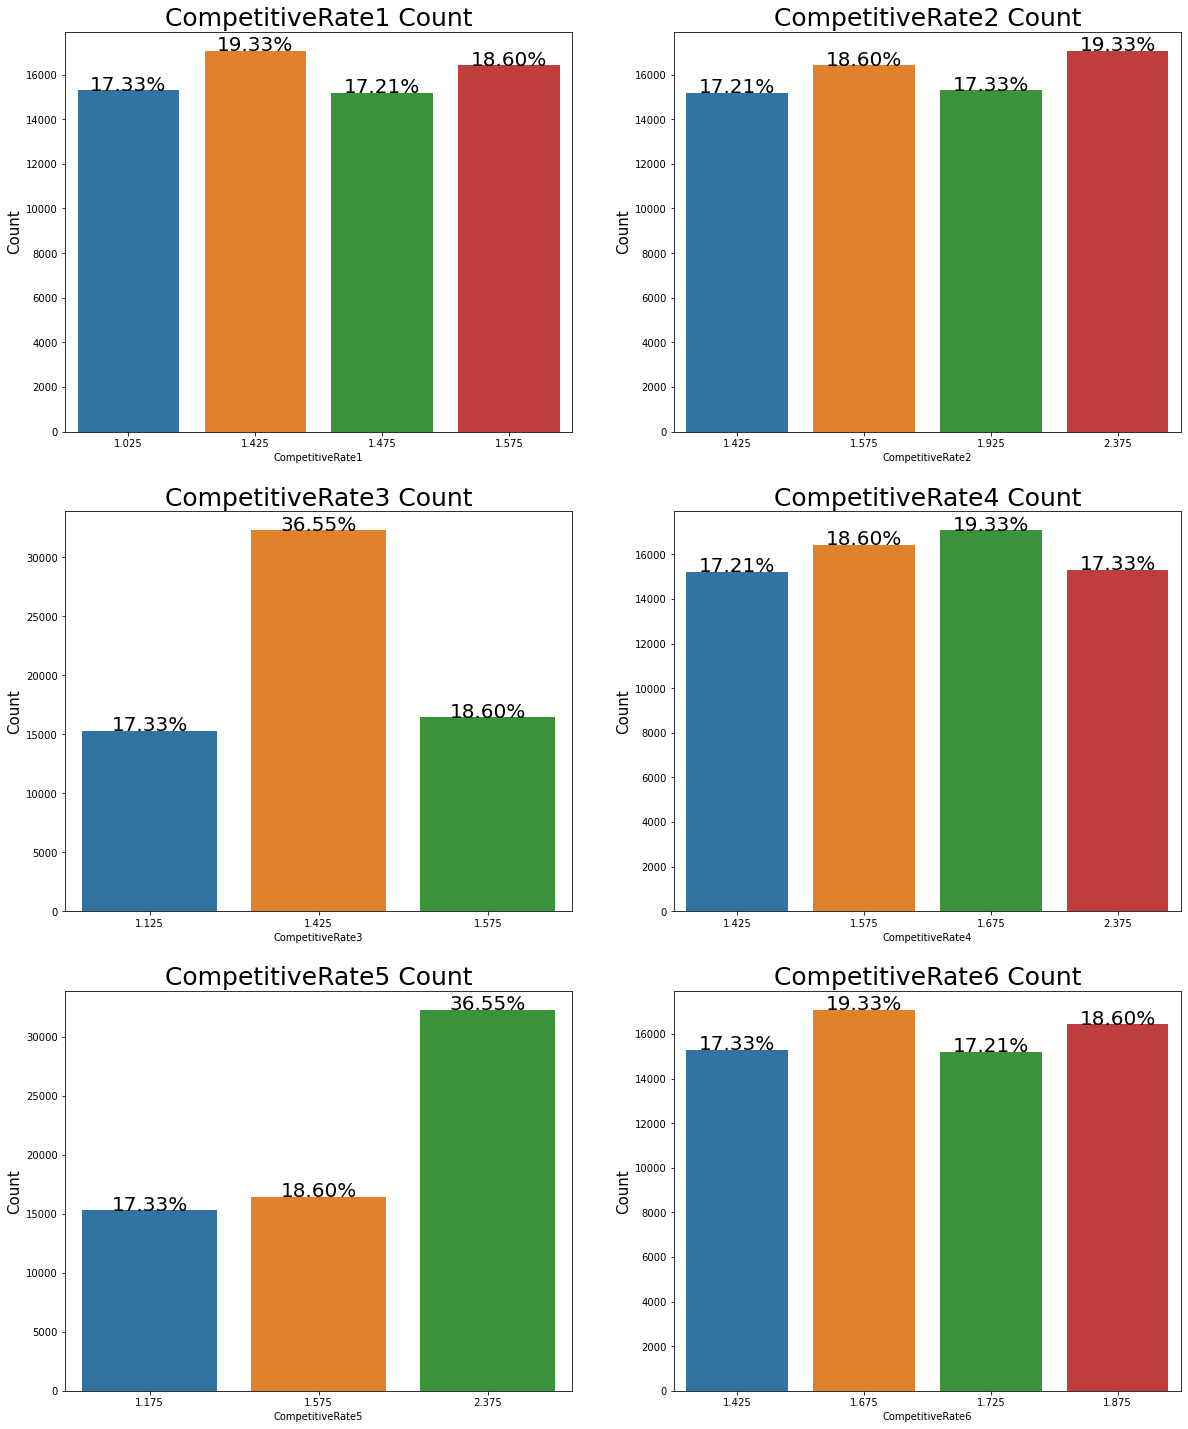

In [25]:
multi_count_plotter(df_comp_rate, 'CompetitiveRate')

### RateBefore Distribution

In [26]:
# utilize list comprehension to get CompRate dataframes from feature_dict funciton
# use concat to convert list of df into one df
df_rate_before = pd.concat([value for (key, value) in feature_dict.items() if 'RateBefore' in key])

# get summary statistics of CompRates
df_rate_before.describe()

,RateBefore
count,63999.000000
mean,1.678434
std,0.160600
min,1.425000
25%,1.675000
50%,1.675000
75%,1.875000
max,1.875000


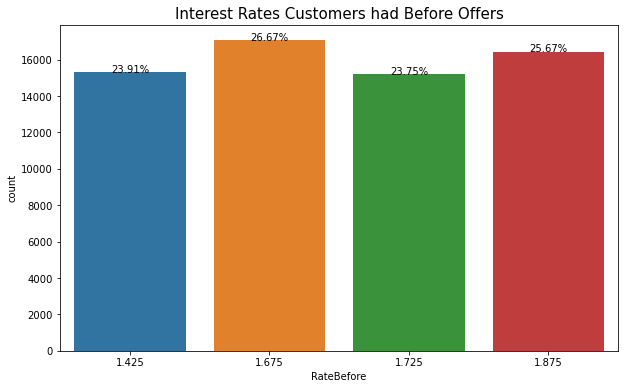

In [27]:
single_count_plotter('RateBefore')

plt.title('Interest Rates Customers had Before Offers', fontsize = 15)
plt.show()

### Reference Rate Distribution

In [28]:
# utilize list comprehension to get CompRate dataframes from feature_dict funciton
# use concat to convert list of df into one df
df_ref_rate = pd.concat([value for (key, value) in feature_dict.items() if 'ReferenceRate' in key], axis = 1)

# get summary statistics for RateBefore
df_ref_rate.describe()

,ReferenceRate
count,63999.000000
mean,1.315226
std,0.106634
min,1.125000
25%,1.375000
50%,1.375000
75%,1.375000
max,1.375000


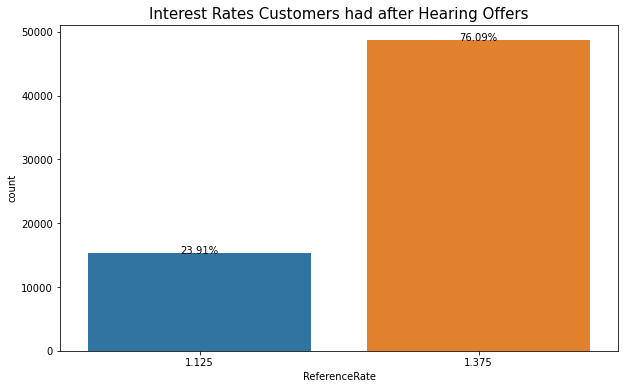

In [29]:
single_count_plotter('ReferenceRate')

plt.title('Interest Rates Customers had after Hearing Offers', fontsize = 15)
plt.show()

## Inspect Product
* not a lot of customers own product 3, only 0.18% of Bank "A" customers own product 3

In [30]:
response_count('Product')

,Product1,Product2,Product3,Product4,Product5,Product6
0,51171,53730,63886,58101,62583,61319
1,12828,10269,113,5898,1416,2680


## Inspect Product Distribution

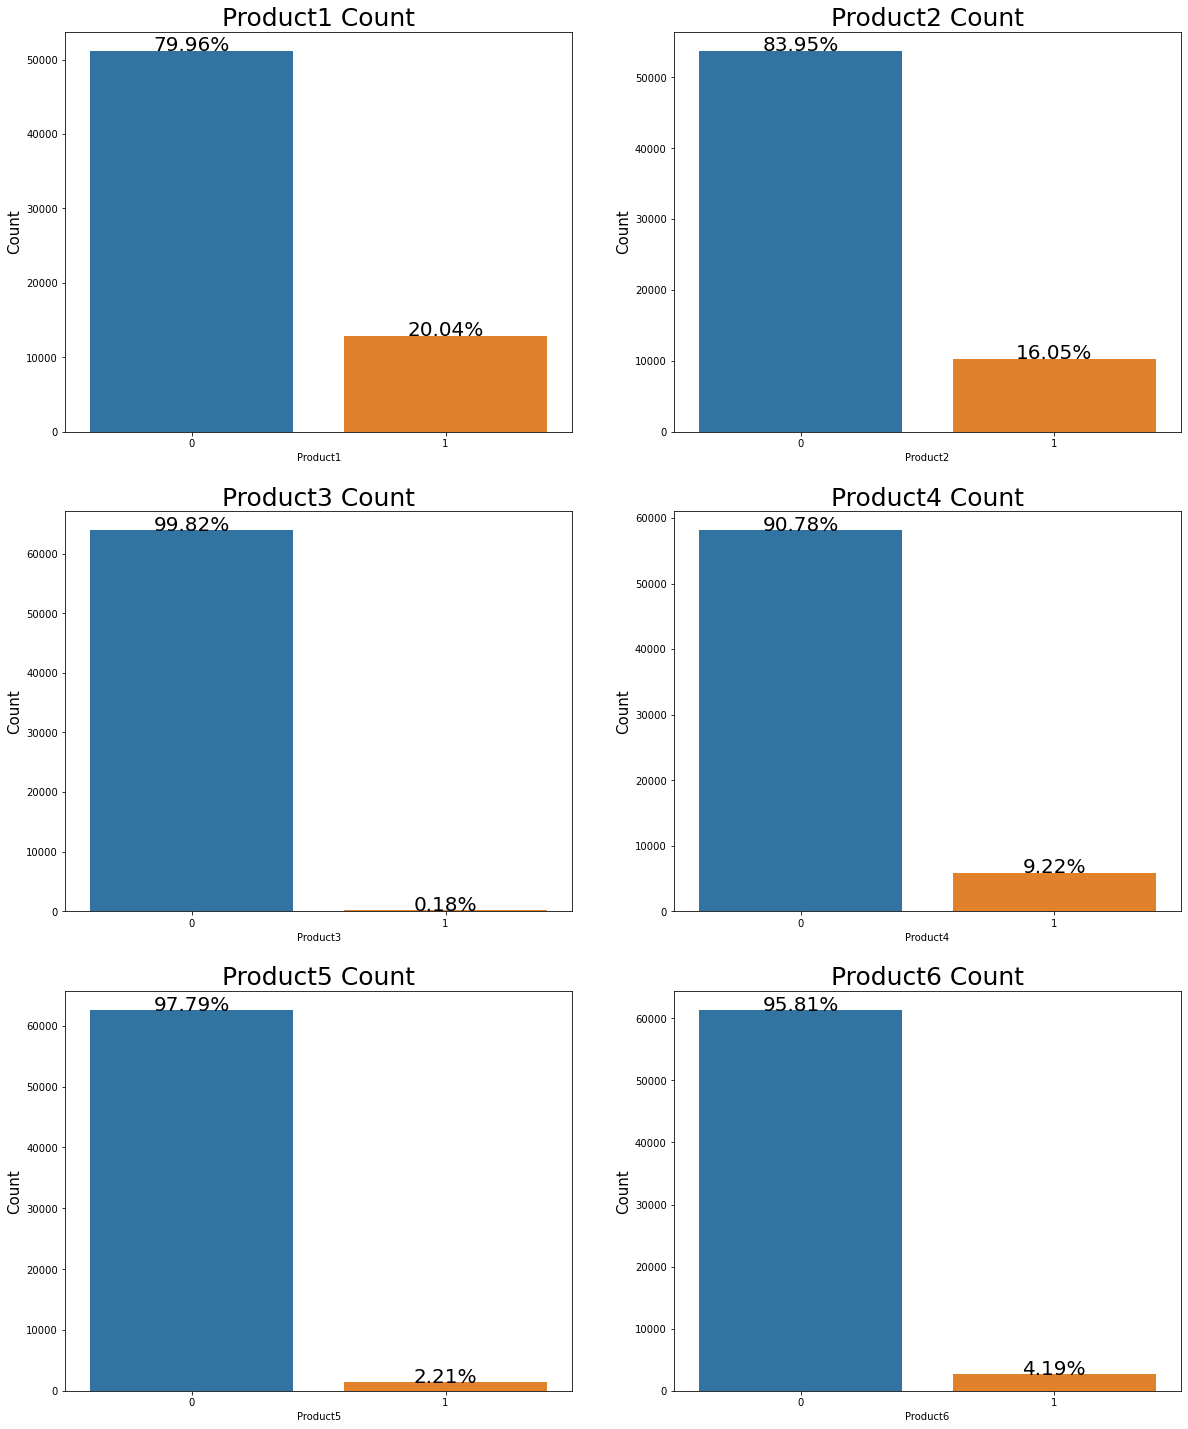

In [31]:
multi_count_plotter(response_count('Product'), 'Product')

## Inspect ExternalAccount

In [32]:
response_count('ExternalAccount')

,ExternalAccount1,ExternalAccount2,ExternalAccount3,ExternalAccount4,ExternalAccount5,ExternalAccount6,ExternalAccount7
0,51389,44677,58717,56077,51720,57572,62763
1,12610,19322,5282,7922,12279,6427,1236


## ExternalAccount Distribution

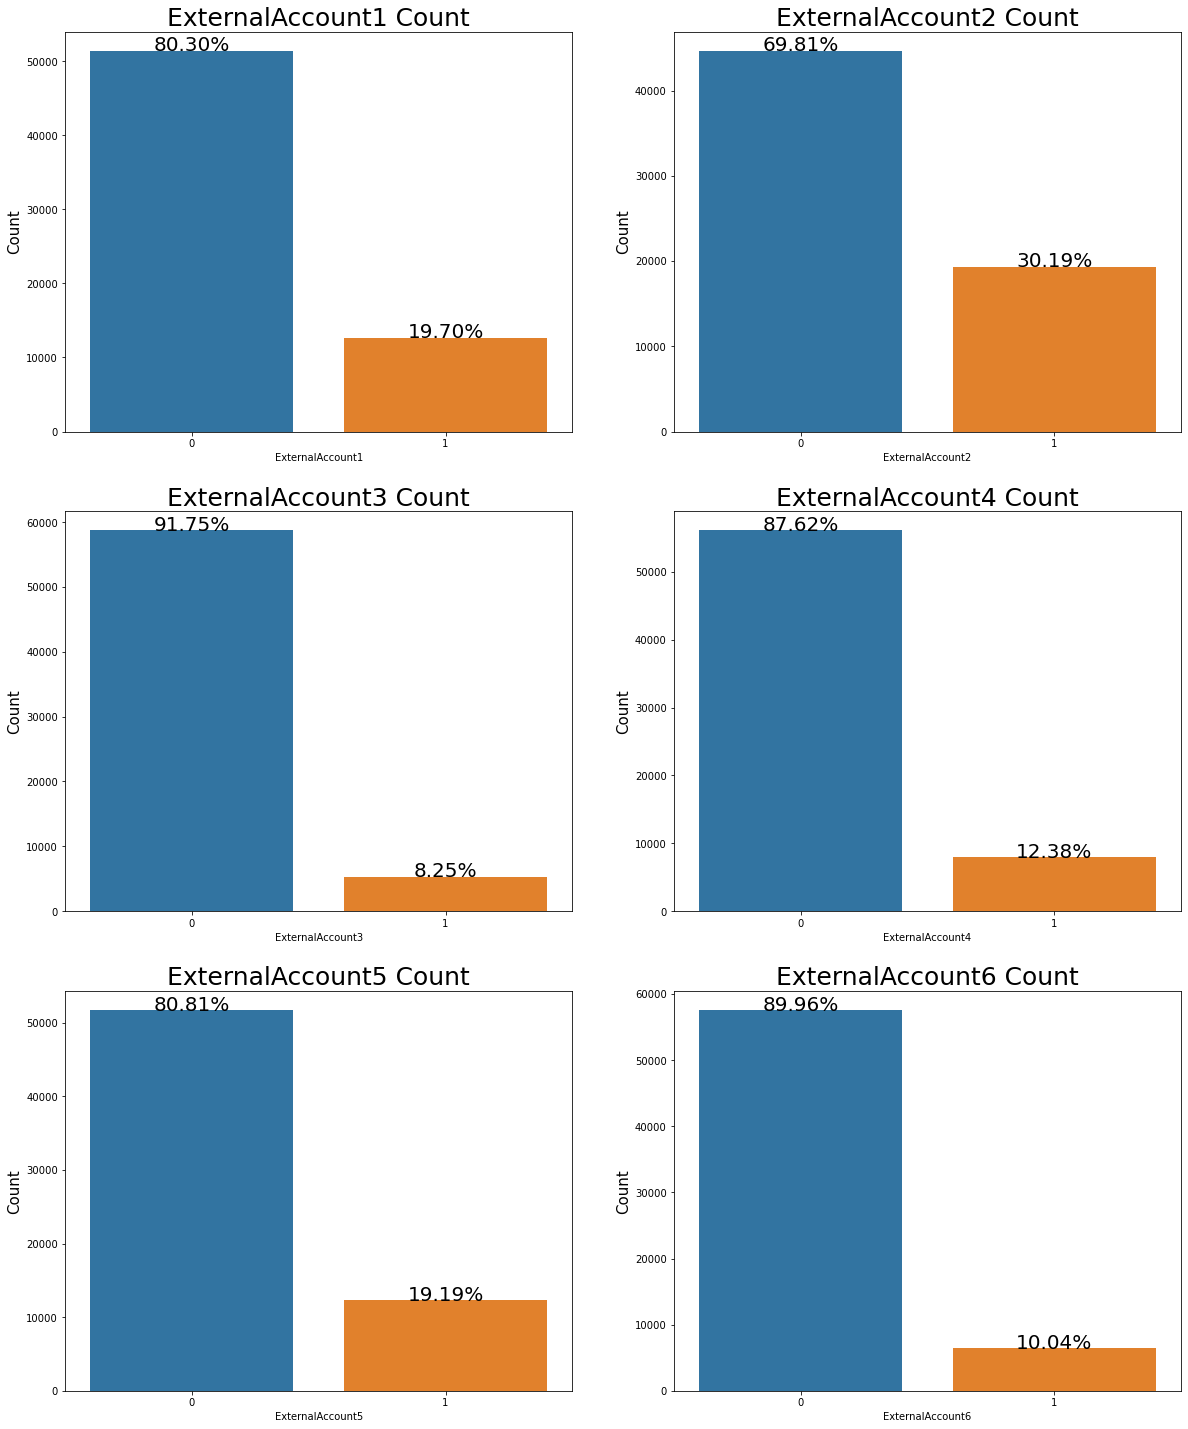

In [33]:
multi_count_plotter(response_count('ExternalAccount'), 'ExternalAccount')

## Inspect Transaction (txn)

In [34]:
# need to include axis = 1 to avoid autofill of NaN for indices that do not align
df_txn = pd.concat([value for (key, value) in feature_dict.items() if 'Transaction' in key], axis = 1)

txn_dict = {}

# total $ amount for each txn
for (k,v) in df_txn.items():

  # save results in a dict
  txn_dict[f'{k}'] = round(df_txn[f'{k}'].sum(), 2)   

txn_dict

{'Transaction1': 20022243.35,
 'Transaction2': 6291521.54,
 'Transaction3': 62235130.45,
 'Transaction4': 854175852.86,
 'Transaction5': 375833514.11,
 'Transaction6': 565237964.89,
 'Transaction7': 6476176.09,
 'Transaction8': 97429213.9,
 'Transaction9': 71914567.47}

In [35]:
df_txn.describe()

,Transaction1,Transaction2,Transaction3,Transaction4,Transaction5,Transaction6,Transaction7,Transaction8,Transaction9
count,63999.000000,63999.000000,63999.000000,63999.000000,6.399900e+04,6.399900e+04,63999.000000,63999.000000,63999.000000
mean,312.852441,98.306560,972.439108,13346.706243,5.872490e+03,8.831981e+03,101.191833,1522.355254,1123.682674
std,4932.061568,897.296635,5903.126316,25046.228309,2.226038e+04,3.051680e+04,894.873343,7410.544303,9570.708952
min,0.000000,0.000000,-34.340000,-33813.000000,0.000000e+00,-2.092436e+04,-957.010000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,5670.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,17500.000000,2.000000e+03,5.500000e+03,0.000000,0.000000,0.000000
max,505000.000000,85500.000000,633506.040000,917005.000000,1.330000e+06,2.029492e+06,36186.980000,297055.190000,513627.920000


In [36]:
# transaction quantiles
df_txn.quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99])

,Transaction1,Transaction2,Transaction3,Transaction4,Transaction5,Transaction6,Transaction7,Transaction8,Transaction9
0.010,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000
0.025,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000
0.100,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000
0.250,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000
0.500,0.0000,0.000,0.000,5670.0000,0.000,0.0000,0.0000,0.0000,0.0000
0.750,0.0000,0.000,0.000,17500.0000,2000.000,5500.0000,0.0000,0.0000,0.0000
0.900,0.0000,0.000,0.000,34831.0580,16460.454,25400.0000,0.0000,0.0000,0.0000
0.975,200.0000,1060.000,13622.812,66500.0000,50000.000,68717.3795,599.5630,23995.8010,10357.8405
0.990,6102.5658,2599.216,24751.251,99317.8944,82000.000,114010.9070,3142.9674,35391.1596,27734.6470


# Feature Engineering 

In [37]:
# # convert Customer_id from object to float type

# # get string value split it right after P and get the number portion of the entire tring
# df_train['CustomerID#'] = df_train['Customer_id'].str.split('P', expand = True)[1]

# df_test['CustomerID#'] = df_test['Customer_id'].str.split('P', expand = True)[1]

In [38]:
df_train = df_train.drop(['Customer_id'], axis = 1)
df_test = df_test.drop(['Customer_id'], axis = 1)

# Individual Models

In [39]:
# define the Plots for Checking the roc_auc values vs Parameter

def plot_Parameters_Vs_Scores(criterion_estimators,roc_auc_values,plotType):
    if plotType == "Scatter":
        plt.scatter(criterion_estimators, roc_auc_values)
    if plotType == "Line":
        plt.plot(criterion_estimators, roc_auc_values) 
    plt.xlabel("Parameters Vs AUC Scores")
    plt.legend(loc="best")
    plt.grid(True)

# Taken from Xuan's reference
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [40]:
# identify target, predicator, categorical, and continous variables 
# for pipeline transformations

Target = 'Target'

col_predictors = [col for col in df_train.columns if col not in [Target]]

col_categorical = []

col_numerical = []

for col in df_train.columns:
    if 'Balance' in col:
        col_numerical.append(col)
    elif 'Transaction' in col:
        col_numerical.append(col)
#     elif 'Rate' in col:
#         col_numerical.append(col)
    elif 'Indicator' in col:
        col_numerical.append(col)
    elif 'Product' in col:          # skip Product feature since it is a binary feature would be redundant to encode
        continue
    elif 'External' in col:         # skip External feature since it is a binary feature would be redundant to encode
        continue
    else:
        col_categorical.append(col)
        
col_categorical.remove('Target')


print(f'TARGET: {Target} \n')
print(f'columns predictors: {col_predictors} \n')
print(f'columns categorical: {col_categorical} \n')
print(f'columns numerical: {col_numerical}')

TARGET: Target 

columns predictors: ['Balance', 'PreviousCampaignResult', 'Product1', 'Product2', 'Product3', 'Product4', 'Product5', 'Product6', 'Transaction1', 'Transaction2', 'Transaction3', 'Transaction4', 'Transaction5', 'Transaction6', 'Transaction7', 'Transaction8', 'Transaction9', 'ExternalAccount1', 'ExternalAccount2', 'ExternalAccount3', 'ExternalAccount4', 'ExternalAccount5', 'ExternalAccount6', 'ExternalAccount7', 'ActivityIndicator', 'RegularInteractionIndicator', 'CompetitiveRate1', 'CompetitiveRate2', 'CompetitiveRate3', 'CompetitiveRate4', 'CompetitiveRate5', 'CompetitiveRate6', 'CompetitiveRate7', 'RateBefore', 'ReferenceRate'] 

columns categorical: ['PreviousCampaignResult', 'CompetitiveRate1', 'CompetitiveRate2', 'CompetitiveRate3', 'CompetitiveRate4', 'CompetitiveRate5', 'CompetitiveRate6', 'CompetitiveRate7', 'RateBefore', 'ReferenceRate'] 

columns numerical: ['Balance', 'Transaction1', 'Transaction2', 'Transaction3', 'Transaction4', 'Transaction5', 'Transaction

## Split train and test data

In [41]:
X = df_train[col_predictors]
y = df_train[Target]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10086, stratify = y) #stratified sampling based on the target

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (47999, 35)
X_test.shape: (16000, 35)
y_train.shape: (47999,)
y_test.shape: (16000,)


## Pipeline Transformations

In [267]:
# Create numerical pipeline to transform numerical values

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder ,StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Convert the non transformed Dataframe into list.
col_categorical_list = list(col_categorical)
col_numerical_list = list(col_numerical)

# for categorical variables
pipeline_categorical = Pipeline([
    ('onehot', OneHotEncoder()),
])

# for numerical variables
pipeline_numerical = Pipeline([
    ('scaler', StandardScaler()),
])

# apply all transformations
pipeline_full = ColumnTransformer([
    ('categorical', pipeline_categorical, col_categorical_list),
    ('numerical', pipeline_numerical, col_numerical_list)
])

pipeline_dim = ColumnTransformer([
    ('reduce_dim', pca_tsne)
])

In [269]:
# trans = pipeline_full.fit(X_train)
# pipeline_dim.fit(trans)
pipeline_full.fit(X_train)

X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)

print(f'X_train transformed.shape: {X_test_transformed.shape}')
print(f'X_test transformed.shape: {X_test_transformed.shape}')

X_train transformed.shape: (4000, 47)
X_test transformed.shape: (4000, 47)


In [44]:
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import \
roc_auc_score, \
accuracy_score, \
roc_curve, \
confusion_matrix, \
precision_score, \
recall_score, \
f1_score, \
precision_recall_curve

## Decision Tree Classifier

Split dataset into 3 sets:
* 70% -> Training and cross validation
* 15% -> Model Stacking
* 15% -> Testing

Tune a decision tree classfier:
* select a score (http://scikit-learn.org/stable/modules/model_evaluation.html). Explain your choice
* tune one parameter a time. Generate a plot for the score vs parameter values. Analyze your results.
    * criterion, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes=None
* tune all parameters at the same time using a randomgrid(http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). First, run with a coarse grid, then refine in the next iteration. Use the information from the previous step to select parameter values.

In [45]:
# Evaluate the Decision tree model on the training set
from sklearn.tree import DecisionTreeClassifier

### First Parameter - criterion
* impurity measure

In [46]:
criterion_estimators_1 = ['gini', 'entropy']

# Establish the first Parameter.
roc_auc_values = []

for item in criterion_estimators_1:
    Dtree_clf = DecisionTreeClassifier(criterion = item, random_state = 42)
    Dtree_clf.fit(X_train_transformed, y_train)
    
    # predict probability of a class being 0 or 1
    y_probas_trees = cross_val_predict(Dtree_clf, X_train_transformed, y_train, cv = 4, method = 'predict_proba')
    y_tree_scores = y_probas_trees[:, 1] # score = proba of positive class
    
    # get roc_auc values for imbalanced binary data classification
    roc_auc_trees = roc_auc_score(y_train, y_tree_scores)
    roc_auc_values.append(roc_auc_trees)

No handles with labels found to put in legend.


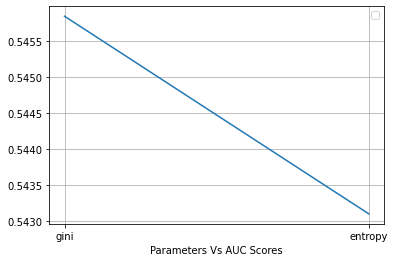

In [47]:
plot_Parameters_Vs_Scores(criterion_estimators_1, roc_auc_values, "Line")
plt.show()

* graph shows gini has a better AUC score than entropy

In [48]:
# parameter to apply to grid search
param_grid_forest_1 = {'criterion' : criterion_estimators_1}

grid_search_1 = GridSearchCV(
    Dtree_clf,            # type of classifier to do grid search on
    param_grid_forest_1,  # dict of parameters to apply to classifier
    cv = 4,               # num of folds for cross validation strategy
    scoring = 'roc_auc',  # Strategy to evaluate the performance of the cross-validated model on the test set
    refit = True          # refit estimator using the best found parameters on the whole dataset, also to get best_estimator
)

# fit the model that has the best parameters
grid_search_1.fit(X_train_transformed, y_train)

best_params_1 = grid_search_1.best_params_          # from grid search get the best paramters that gave the best scores for training data
best_estimators_1 = grid_search_1.best_estimator_   # from grid search get the best estimators that gave the best scores for testing data

print(f'The best parameter for {best_params_1}')
print(f'These are thus the best parameters for {best_estimators_1}')

The best parameter for {'criterion': 'gini'}
These are thus the best parameters for DecisionTreeClassifier(random_state=42)


In [49]:
#Print the accuracy score
print(best_estimators_1.score(X_train_transformed, y_train))

1.0


In [99]:
# Check the Accuracy on Test data 
y_test_estimations_1 = best_estimators_1.predict(X_test_transformed)

print(accuracy_score(y_test, y_test_estimations_1))

0.5495


### First Parameter Analysis
Model is **overfitting** since the score on the training dataset is 100% but the score on the test data is 54%. The model is doing very well for the training but horribly on the test data.

### Second Parameter - Max Depth
* regularization of model to reduce overfitting

In [51]:
# Criterion Parameter - Max Depth

criterion_estimators_2 = [1, 2, 3, 4, 5]

roc_auc_values = []

for item in criterion_estimators_2:
    Dtree_clf = DecisionTreeClassifier(max_depth=item, random_state = 42)
    Dtree_clf.fit(X_train_transformed, y_train)

    y_probas_trees = cross_val_predict(Dtree_clf, X_train_transformed, y_train, cv = 4, method = 'predict_proba')
    
    y_tree_scores = y_probas_trees[:, 1] # score = proba of positive class
    
    roc_auc_trees = roc_auc_score(y_train,y_tree_scores)
    roc_auc_values.append(roc_auc_trees)

No handles with labels found to put in legend.


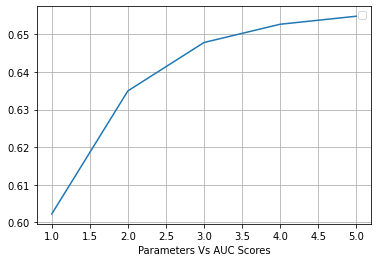

In [52]:
plot_Parameters_Vs_Scores(criterion_estimators_2, roc_auc_values,"Line")
plt.show()

* graph shows that map depth = 5 gives the best AUC score

In [53]:
param_grid_forest_2 = {'max_depth' : criterion_estimators_2}

grid_search_2 = GridSearchCV(
    Dtree_clf,            # type of classifier to do grid search on
    param_grid_forest_2,  # dict of parameters to apply to classifier
    cv = 4,               # num of folds for cross validation strategy
    scoring = 'roc_auc',  # Strategy to evaluate the performance of the cross-validated model on the test set
    refit = True          # refit estimator using the best found parameters on the whole dataset, also to get best_estimator
)

# fit the model that has the best parameters
grid_search_2.fit(X_train_transformed, y_train)

best_params_2 = grid_search_2.best_params_          # from grid search get the best paramters that gave the best scores for training data
best_estimators_2 = grid_search_2.best_estimator_   # from grid search get the best estimators that gave the best scores for testing data

print(best_params_2)
print(best_estimators_2)

{'max_depth': 5}
DecisionTreeClassifier(max_depth=5, random_state=42)


In [54]:
#Print the accuracy score
print(best_estimators_2.score(X_train_transformed, y_train))

0.6259297068688932


In [55]:
#Check the Accuracy on Test data 

y_test_estimations_2 = best_estimators_2.predict(X_test_transformed)
print(accuracy_score(y_test, y_test_estimations_2))

0.618375


### Second Parameter Analysis - Max Depth
* overfitting is reduced as indicated by the lower accuracy on training set

### Third Parameter - Min sample split

In [56]:
# Criterion = Min Samples Split.
criterion_estimators_3 = list(range(2,10))  # [2, 10) exclusive, run a range of min sample split numbers

roc_auc_values = []

for item in criterion_estimators_3:
    Dtree_clf = DecisionTreeClassifier(min_samples_split = item, random_state = 42)
    Dtree_clf.fit(X_train_transformed, y_train)

    y_probas_trees = cross_val_predict(Dtree_clf, X_train_transformed, y_train, cv = 4, method="predict_proba")
    y_tree_scores = y_probas_trees[:, 1] # score = proba of positive class
    roc_auc_trees = roc_auc_score(y_train, y_tree_scores)
    roc_auc_values.append(roc_auc_trees)

No handles with labels found to put in legend.


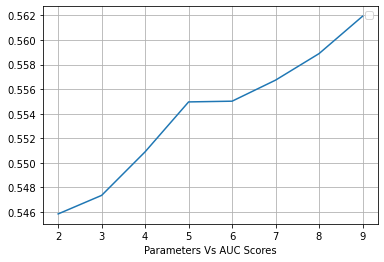

In [57]:
plot_Parameters_Vs_Scores(criterion_estimators_3, roc_auc_values,"Line")
plt.show()

* graph shows that min sample split = 9 gives the best AUC scores

In [58]:
# Set the min_samples_split to None as this parameter keeps increasing at a decreasing rate. 
# But a higher score is generated with 20 as min sample split

param_grid_forest_3 = {'min_samples_split' : criterion_estimators_3}

grid_search_3 = GridSearchCV(
    Dtree_clf,            # type of classifier to do grid search on
    param_grid_forest_3,  # dict of parameters to apply to classifier
    cv = 4,               # num of folds for cross validation strategy
    scoring = 'roc_auc',  # Strategy to evaluate the performance of the cross-validated model on the test set
    refit = True          # refit estimator using the best found parameters on the whole dataset, also to get best_estimator
)

# fit the model with the best parameters determined by grid search
grid_search_3.fit(X_train_transformed, y_train)

best_params_3 = grid_search_3.best_params_          # from grid search get the best paramters that gave the best scores for training data
best_estimators_3 = grid_search_3.best_estimator_   # from grid search get the best estimators that gave the best scores for testing data

print(best_params_3)
print(best_estimators_3)

{'min_samples_split': 9}
DecisionTreeClassifier(min_samples_split=9, random_state=42)


In [59]:
# Print the accuracy score
print(best_estimators_3.score(X_train_transformed,y_train))

0.8848934352799017


In [60]:
# Check the Accuracy on Test data 
from sklearn.metrics import accuracy_score

y_test_estimations_3 = best_estimators_3.predict(X_test_transformed)
print(accuracy_score(y_test, y_test_estimations_3))

0.5504375


### Third Parameter Min Sample Test - Analysis
* model is overfitting on the training data

### Fourth Parameter - Min Sample Leaf

In [61]:
# Criteria : min_samples_leaf
criterion_estimators_4 = [(i + 1) / 10 for i in range(5)]

roc_auc_values = []

for item in criterion_estimators_4:
    Dtree_clf = DecisionTreeClassifier(min_samples_leaf = item, random_state = 42)
    Dtree_clf.fit(X_train_transformed,y_train)

    y_probas_trees = cross_val_predict(Dtree_clf, X_train_transformed, y_train, cv = 4, method = 'predict_proba')
    y_tree_scores = y_probas_trees[:, 1] # score = proba of positive class
    roc_auc_trees = roc_auc_score(y_train,y_tree_scores)
    roc_auc_values.append(roc_auc_trees)

No handles with labels found to put in legend.


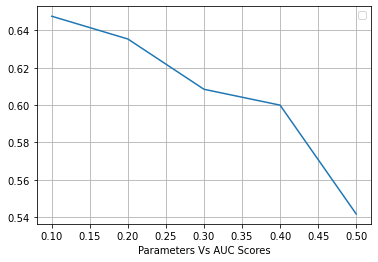

In [62]:
plot_Parameters_Vs_Scores(criterion_estimators_4, roc_auc_values, 'Line')
plt.show()

In [63]:
param_grid_forest_4 = {'min_samples_leaf' : criterion_estimators_4}

grid_search_4 = GridSearchCV(
    Dtree_clf,            # type of classifier to do grid search on
    param_grid_forest_4,  # dict of parameters to apply to classifier
    cv = 4,               # num of folds for cross validation strategy
    scoring = 'roc_auc',  # Strategy to evaluate the performance of the cross-validated model on the test set
    refit = True          # refit estimator using the best found parameters on the whole dataset, also to get best_estimator
)

# fit the model with the best parameters determined by grid search
grid_search_4.fit(X_train_transformed, y_train)

best_params_4 = grid_search_4.best_params_          # from grid search get the best paramters that gave the best scores for training data
best_estimators_4 = grid_search_4.best_estimator_   # from grid search get the best estimators that gave the best scores for testing data


print(best_params_4)
print(best_estimators_4)

{'min_samples_leaf': 0.1}
DecisionTreeClassifier(min_samples_leaf=0.1, random_state=42)


In [64]:
#Print the accuracy score
print(best_estimators_4.score(X_train_transformed, y_train))

0.6117835788245588


In [65]:
#Check the Accuracy on Test data 
from sklearn.metrics import accuracy_score

y_test_estimations_4 = best_estimators_4.predict(X_test_transformed)

print(accuracy_score(y_test, y_test_estimations_4))

0.610625


### Fourth Parameter Min Sample Leaf - Analysis
* with min sample leaf = 0.1 we get resonable accuracy on test data

### Fifth Parameter - Max Leaf Nodes

In [66]:
#Criterion = max_leaf_nodes
criterion_estimators_5 = list(range(2, 35))

roc_auc_values = []

for item in criterion_estimators_5:
    Dtree_clf = DecisionTreeClassifier(max_leaf_nodes = item, random_state = 42)
    Dtree_clf.fit(X_train_transformed, y_train)

    y_probas_trees = cross_val_predict(Dtree_clf, X_train_transformed, y_train, cv = 4, method = 'predict_proba')
    y_tree_scores = y_probas_trees[:, 1] # score = proba of positive class
    roc_auc_trees = roc_auc_score(y_train, y_tree_scores)
    roc_auc_values.append(roc_auc_trees)

In [67]:
param_grid_forest_5 = {'max_leaf_nodes' : criterion_estimators_5}

grid_search_5 = GridSearchCV(
    Dtree_clf, 
    param_grid_forest_5, 
    cv = 4, 
    scoring='roc_auc', 
    refit = True
)

grid_search_5.fit(X_train_transformed, y_train)

best_params_5 = grid_search_5.best_params_
best_estimators_5 = grid_search_5.best_estimator_

print(best_params_5)
print(best_estimators_5)

{'max_leaf_nodes': 26}
DecisionTreeClassifier(max_leaf_nodes=26, random_state=42)


In [68]:
#Print the accuracy score
print(best_estimators_5.score(X_train_transformed, y_train))

0.6241171691076898


In [69]:
#Check the Accuracy on Test data 
from sklearn.metrics import accuracy_score

y_test_estimations_5 = best_estimators_5.predict(X_test_transformed)

print(accuracy_score(y_test, y_test_estimations_5))

0.618375


### Fifth Parameter Max Leaf Nodes - Analysis
* 

# Tune all paramaters using randomgrid

In [152]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [270]:
#tuning all the parameters together 
parameter_distribution = {
    'criterion' : criterion_estimators_1, 
    'max_depth' : criterion_estimators_2,
    'min_samples_split' : criterion_estimators_3, 
    'min_samples_leaf' : criterion_estimators_4,
    'max_leaf_nodes' : criterion_estimators_5
}

rnd_search_cv = RandomizedSearchCV(Dtree_clf, parameter_distribution, n_iter=10, verbose=2)
rnd_search_cv.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=26, min_samples_leaf=0.2, min_samples_split=3; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=26, min_samples_leaf=0.2, min_samples_split=3; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=26, min_samples_leaf=0.2, min_samples_split=3; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=26, min_samples_leaf=0.2, min_samples_split=3; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=26, min_samples_leaf=0.2, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=4, min_samples_leaf=0.2, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=4, min_samples_leaf=0.2, min_samples_split=8; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=4, min_samples_leaf=0.2, min_samples_spl

RandomizedSearchCV(estimator=DecisionTreeClassifier(max_leaf_nodes=34,
                                                    random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, 31, ...],
                                        'min_samples_leaf': [0.1, 0.2, 0.3, 0.4,
                                                             0.5],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
               

In [271]:
# Get the best estimator on Randomized SearchCV
rnd_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=7, min_samples_leaf=0.4,
                       min_samples_split=6, random_state=42)

In [272]:
rnd_search_cv.score(X_train_transformed, y_train)

0.6022625471363987

In [273]:
# Based on the accuracy scores, we select the best estimator and work with the test set
from sklearn.metrics import accuracy_score

final_model = rnd_search_cv.best_estimator_ # best estimator with accuracy over 99%

y_test_estimations = final_model.predict(X_test_transformed)

print(accuracy_score(y_test, y_test_estimations))

0.6045


### ROC Curve for Decision Tree Random Search

In [274]:
# evaluate random search cv on training set
y_probas_rnd_search = cross_val_predict(
    rnd_search_cv, 
    X_train_transformed, 
    y_train, 
    cv = 4, 
    method = 'predict_proba'
)

y_rnd_search_scores = y_probas_rnd_search[:, 1] # score = proba of positive class

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=33, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=33, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=33, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=33, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=33, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=25, min_samples_leaf=0.5, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=25, min_samples_leaf=0.5, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=25, min_samples_leaf=0.5, min_samples_

[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=29, min_samples_leaf=0.3, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=6, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=6, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=6, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=6, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=6, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=15, min_samples_leaf=0.1, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=15, min_samples_leaf=0.1, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nod

[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=6, min_samples_leaf=0.1, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=6, min_samples_leaf=0.1, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=31, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=31, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=31, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=31, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=31, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_leaf_nodes=8, min_samples_leaf=0.2, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_lea

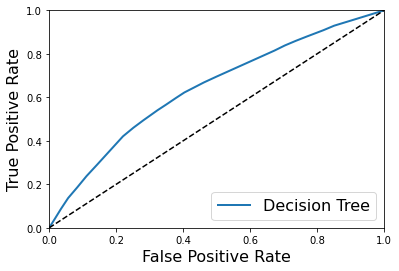

In [275]:
# for random search
# fpr = false positive rate
# tpr = true positive rate

fpr_rnd_search, tpr_rnd_search, thresholds_rnd_search = roc_curve(y_train, y_rnd_search_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
#Plot the Roc Curve
plot_roc_curve(fpr_rnd_search, tpr_rnd_search, 'Decision Tree')
plt.legend(loc = 'lower right', fontsize = 16)
plt.show()

### AUC of Random Search

In [276]:
auc_rnd_search = roc_auc_score(y_train, y_rnd_search_scores)

print(auc_rnd_search)

0.6399554649761469


### Confusion Matrix for Random Search

In [277]:
# need to create a binary classifier as Classification metrics can't handle a mix of binary and continuous targets
predict_rnd_search = cross_val_predict(
    rnd_search_cv,
    X_train_transformed,
    y_train, 
    cv=10
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=7, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=7, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=7, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=7, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=7, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=24, min_samples_leaf=0.4, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=24, min_samples_leaf=0.4, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=24, min_samples_leaf=0.4, min_samples_split

[CV] END criterion=gini, max_depth=5, max_leaf_nodes=6, min_samples_leaf=0.2, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=6, min_samples_leaf=0.2, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=6, min_samples_leaf=0.2, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=6, min_samples_leaf=0.2, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=6, min_samples_leaf=0.2, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=30, min_samples_leaf=0.3, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=30, min_samples_leaf=0.3, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=30, min_samples_leaf=0.3, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max

[CV] END criterion=gini, max_depth=1, max_leaf_nodes=15, min_samples_leaf=0.1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_leaf_nodes=15, min_samples_leaf=0.1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=31, min_samples_leaf=0.2, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=31, min_samples_leaf=0.2, min_samples_split=2; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=31, min_samples_leaf=0.2, min_samples_split=2; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=31, min_samples_leaf=0.2, min_samples_split=2; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=31, min_samples_leaf=0.2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.1, min_samples_split=9; total time=   0.1s
[CV] END criterion=gini, max_dept

[CV] END criterion=gini, max_depth=5, max_leaf_nodes=18, min_samples_leaf=0.2, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=18, min_samples_leaf=0.2, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=18, min_samples_leaf=0.2, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=18, min_samples_leaf=0.2, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=18, min_samples_leaf=0.2, min_samples_split=7; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=21, min_samples_leaf=0.3, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=21, min_samples_leaf=0.3, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=21, min_samples_leaf=0.3, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=2

[CV] END criterion=gini, max_depth=4, max_leaf_nodes=20, min_samples_leaf=0.1, min_samples_split=3; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=28, min_samples_leaf=0.1, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=28, min_samples_leaf=0.1, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=28, min_samples_leaf=0.1, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=28, min_samples_leaf=0.1, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=28, min_samples_leaf=0.1, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.2, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.2, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_n

[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=31, min_samples_leaf=0.5, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=25, min_samples_leaf=0.5, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=25, min_samples_leaf=0.5, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=25, min_samples_leaf=0.5, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=25, min_samples_leaf=0.5, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=25, min_samples_leaf=0.5, min_samples_split=6; total time=   0.0s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=29, min_samples_leaf=0.3, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=29, min_samples_leaf=0.3, min_sampl

[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=10, min_samples_leaf=0.1, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=10, min_samples_leaf=0.1, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=10, min_samples_leaf=0.1, min_samples_split=8; total time=   0.1s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=5, min_samples_leaf=0.4, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=5, min_samples_leaf=0.4, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=5, min_samples_leaf=0.4, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=5, min_samples_leaf=0.4, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=5, min_samples_leaf=0.4, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max

[CV] END criterion=gini, max_depth=4, max_leaf_nodes=8, min_samples_leaf=0.3, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=8, min_samples_leaf=0.3, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=8, min_samples_leaf=0.3, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=18, min_samples_leaf=0.1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=18, min_samples_leaf=0.1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=18, min_samples_leaf=0.1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=18, min_samples_leaf=0.1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=18, min_samples_leaf=0.1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_dept

In [278]:
confusion_matrix(y_train, predict_rnd_search)

array([[13966, 10044],
       [ 8924, 15065]], dtype=int64)

### Precision and Recall Scores for Random Search

In [279]:
print(f'Precision Score: {precision_score(y_train, predict_rnd_search)}')
print(f'Recall Score: {recall_score(y_train, predict_rnd_search)}')

Precision Score: 0.5999840694571668
Recall Score: 0.6279961649089166


### F1 Score for Random Search

In [280]:
print(f'F1 Score: {f1_score(y_train, predict_rnd_search)}')

F1 Score: 0.6136706179477779


### Create Precision - Recall Curve

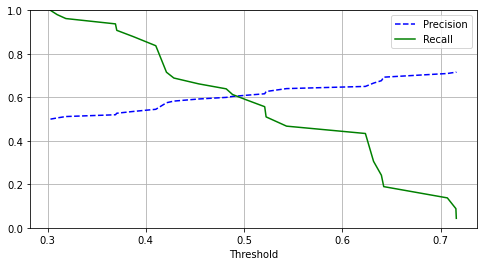

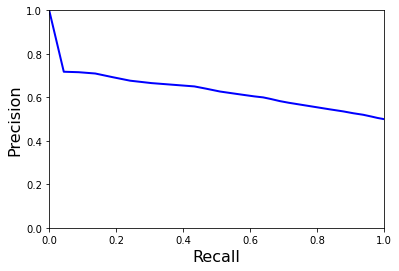

In [164]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_rnd_search_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

    
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [174]:
# Current precision - recall is 0.6046796987391047 - 0.5957313768810705
# To change the threshholds, we consider changing the probabilities generated from the method = predict_proba

Recall_Threshold = (y_rnd_search_scores > .4)

print(f'Precision Score: {precision_score(y_train, Recall_Threshold)}')
print(f'Recall Score: {recall_score(y_train, Recall_Threshold)}')

Recall_Threshold

Precision Score: 0.5435952928445827
Recall Score: 0.8376339155446246


array([ True,  True,  True, ...,  True, False, False])

In [175]:
Average_Score = cross_val_score(
    rnd_search_cv, 
    X_train_transformed, 
    Recall_Threshold, 
    cv = 4, 
    scoring = 'accuracy'
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=gini, max_depth=1, max_leaf_nodes=13, min_samples_leaf=0.1, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_leaf_nodes=13, min_samples_leaf=0.1, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_leaf_nodes=13, min_samples_leaf=0.1, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_leaf_nodes=13, min_samples_leaf=0.1, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_leaf_nodes=13, min_samples_leaf=0.1, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=29, min_samples_leaf=0.1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=29, min_samples_leaf=0.1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=29, min_samples_leaf=0.1, min_samples_split=2; total 

[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=30, min_samples_leaf=0.5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=14, min_samples_leaf=0.3, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=14, min_samples_leaf=0.3, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=14, min_samples_leaf=0.3, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=14, min_samples_leaf=0.3, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=14, min_samples_leaf=0.3, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=17, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=17, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_lea

[CV] END criterion=gini, max_depth=4, max_leaf_nodes=2, min_samples_leaf=0.3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=2, min_samples_leaf=0.3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=2, min_samples_leaf=0.3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=2, min_samples_leaf=0.3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=2, min_samples_leaf=0.3, min_samples_split=7; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=24, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=24, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=24, min_samples_leaf=0.5, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max

In [176]:
print(Average_Score) # [ 0.72333333  0.727       0.7195      0.71966667]

print(np.average(Average_Score))

[0.8545     0.72291667 0.83558333 0.86807234]
0.8202680848404034


### Use New Threshold on Random Search

In [177]:
New_Threshhold = Recall_Threshold.astype(int)

rnd_search_cv_threshold = RandomizedSearchCV(Dtree_clf, parameter_distribution, n_iter = 10, verbose = 2)
rnd_search_cv_threshold.fit(X_train_transformed, New_Threshhold)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=25, min_samples_leaf=0.4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=25, min_samples_leaf=0.4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=25, min_samples_leaf=0.4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=25, min_samples_leaf=0.4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=25, min_samples_leaf=0.4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=33, min_samples_leaf=0.4, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=33, min_samples_leaf=0.4, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=33, min_samples_leaf=0.4, min_samples_split=

RandomizedSearchCV(estimator=DecisionTreeClassifier(max_leaf_nodes=34,
                                                    random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, 31, ...],
                                        'min_samples_leaf': [0.1, 0.2, 0.3, 0.4,
                                                             0.5],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
               

In [178]:
rnd_search_cv_threshold.best_estimator_           # Get the best estimator on Randomized SearchCV w/ threshold

rnd_search_cv_threshold.score(X_train_transformed, y_train)   # check accuracy

0.5805537615366987

In [170]:
# based on best estimator and test on test set
final_model = rnd_search_cv_threshold.best_estimator_ #best estimator with accuracy over 99%

y_pred = final_model.predict(X_test_transformed)

print(accuracy_score(y_test, y_pred))

0.56325


In [179]:
# evaluate random search w/ threshold on training set
y_probas_rnd_search_threshold = cross_val_predict(
    rnd_search_cv_threshold, 
    X_train_transformed, 
    y_train, 
    cv = 4, 
    method = 'predict_proba'
)

y_rnd_search_threshold_scores = y_probas_rnd_search_threshold[:, 1] # score = proba of positive class

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=21, min_samples_leaf=0.1, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=21, min_samples_leaf=0.1, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=21, min_samples_leaf=0.1, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=21, min_samples_leaf=0.1, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=21, min_samples_leaf=0.1, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=12, min_samples_leaf=0.1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=12, min_samples_leaf=0.1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=12, min_samples_leaf=0.1, min

[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.2, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=31, min_samples_leaf=0.2, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=31, min_samples_leaf=0.2, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=31, min_samples_leaf=0.2, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=1

[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=21, min_samples_leaf=0.3, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=21, min_samples_leaf=0.3, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=21, min_samples_leaf=0.3, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=21, min_samples_leaf=0.3, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=21, min_samples_leaf=0.3, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=25, min_samples_leaf=0.2, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=25, min_samples_leaf=0.2, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=25, min_samples_leaf=0.2, min_samples_split=2; total time=   0.0s
[CV] END criterion=entro

### ROC Curve of decision tree w/ random search and threshold

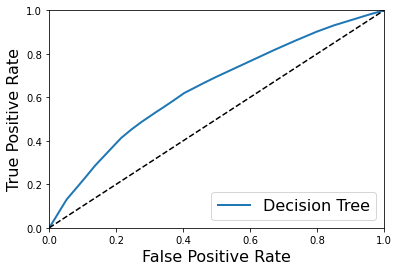

In [182]:
fpr_rnd_search, tpr_rnd_search, thresholds_rnd_search = roc_curve(y_train, y_rnd_search_threshold_scores)

#Plot the Roc Curve
plot_roc_curve(fpr_rnd_search, tpr_rnd_search, 'Decision Tree')
plt.legend(loc = 'lower right', fontsize = 16)
plt.show()

### AUC of decision tree w/ random search and threshold

In [183]:
auc_rnd_search_threshold = roc_auc_score(y_train, y_rnd_search_threshold_scores)

print(auc_rnd_search_threshold)

0.6407512213749087


In [184]:
# need to create a binary classifier as Classification metrics can't handle a mix of binary and continuous targets
predict_rnd_search_threshold = cross_val_predict(
    rnd_search_cv_threshold,
    X_train_transformed,
    y_train, 
    cv=10
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.1, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.1, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.1, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.1, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.1, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=23, min_samples_leaf=0.4, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=23, min_samples_leaf=0.4, min_samples_split=4; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, max_leaf_nodes=23, min_samples_leaf=0.4, min

[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=22, min_samples_leaf=0.1, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=20, min_samples_leaf=0.2, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=20, min_samples_leaf=0.2, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=20, min_samples_leaf=0.2, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=20, min_samples_leaf=0.2, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=20, min_samples_leaf=0.2, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=26, min_samples_leaf=0.5, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=26, min_samples_leaf=0.5, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_lea

[CV] END criterion=gini, max_depth=2, max_leaf_nodes=28, min_samples_leaf=0.1, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=28, min_samples_leaf=0.1, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.5, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.5, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.5, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.5, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=19, min_samples_leaf=0.5, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=22, min_samples_leaf=0.5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_n

[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=30, min_samples_leaf=0.2, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=30, min_samples_leaf=0.2, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=30, min_samples_leaf=0.2, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=30, min_samples_leaf=0.2, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=14, min_samples_leaf=0.1, min_samples_split=3; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=14, min_samples_leaf=0.1, min_samples_split=3; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=14, min_samples_leaf=0.1, min_samples_split=3; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=14, min_samples_leaf=0.1, min_samples_split=3; total time=   0.0s
[CV] END criterion=entro

[CV] END criterion=gini, max_depth=4, max_leaf_nodes=26, min_samples_leaf=0.3, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=26, min_samples_leaf=0.3, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=26, min_samples_leaf=0.3, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=26, min_samples_leaf=0.3, min_samples_split=6; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=26, min_samples_leaf=0.3, min_samples_split=6; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=14, min_samples_leaf=0.1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=14, min_samples_leaf=0.1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=14, min_samples_leaf=0.1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=2

[CV] END criterion=entropy, max_depth=3, max_leaf_nodes=30, min_samples_leaf=0.1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=12, min_samples_leaf=0.5, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=12, min_samples_leaf=0.5, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=12, min_samples_leaf=0.5, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=12, min_samples_leaf=0.5, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=12, min_samples_leaf=0.5, min_samples_split=5; total time=   0.0s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=17, min_samples_leaf=0.5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_leaf_nodes=17, min_samples_leaf=0.5, min_samples_split=8; tot

[CV] END criterion=gini, max_depth=5, max_leaf_nodes=29, min_samples_leaf=0.4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.1, min_samples_split=4; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.1, min_samples_split=4; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=16, min_samples_leaf=0.1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=15, min_samples_leaf=0.1, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=15, min_samples_leaf=0.1, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_leaf_n

[CV] END criterion=gini, max_depth=5, max_leaf_nodes=33, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_leaf_nodes=33, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=8, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=8, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=8, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=8, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=8, min_samples_leaf=0.5, min_samples_split=3; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=22, min_samples_leaf=0.2, min_samples_split=3; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_

In [185]:
confusion_matrix(y_train, predict_rnd_search_threshold)

array([[13858, 10152],
       [ 8777, 15212]], dtype=int64)

In [247]:
print(f'Precision Score: {precision_score(y_train, predict_rnd_search)}')
print(f'Recall Score: {recall_score(y_train, predict_rnd_search)}')
print(f'F1 Score: {f1_score(y_train, predict_rnd_search)}')

Precision Score: 0.6062543493389004
Recall Score: 0.5810579849097502
F1 Score: 0.5933888167557098


# Stacking Ensemble 

In [244]:
from sklearn.ensemble import \
RandomForestClassifier, \
AdaBoostClassifier, \
ExtraTreesClassifier, \
GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

In [245]:
X_train, X_nontrain, y_train, y_nontrain = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=10086, 
    stratify = y          #stratified sampling based on the target
) 

print(f'X_train.shape: {X_train.shape}')
print(f'X_nontrain.shape: {X_nontrain.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_nontrain.shape: {y_nontrain.shape}')

X_stack, X_test, y_stack, y_test = train_test_split(
    X_nontrain, 
    y_nontrain, 
    test_size = 0.25, 
    random_state = 10086, 
    stratify = y_nontrain    #stratified sampling based on the target
) 
print(f'X_stack.shape: {X_stack.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_stack.shape: {y_stack.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (47999, 35)
X_nontrain.shape: (16000, 35)
y_train.shape: (47999,)
y_nontrain.shape: (16000,)
X_stack.shape: (12000, 35)
X_test.shape: (4000, 35)
y_stack.shape: (12000,)
y_test.shape: (4000,)


In [246]:
pipeline_full.fit(X_train)
X_train_transformed = pipeline_full.transform(X_train)
X_stack_transformed = pipeline_full.transform(X_stack)
X_test_transformed = pipeline_full.transform(X_test)


print(f'X_train_transformed.shape: {X_train_transformed.shape}')
print(f'X_test_transformed.shape: {X_test_transformed.shape}')
print(f'X_stack_transformed.shape: {X_stack_transformed.shape}')

X_train_transformed.shape: (47999, 47)
X_test_transformed.shape: (4000, 47)
X_stack_transformed.shape: (12000, 47)


## Random Forest Classifier

In [190]:
# Random Forest Classifier

# parameter values
n_estimators = [10, 200]
max_features = [0.1, 0.5]
max_depth = [2, 10, 20] 
oob_score = [True, False]
min_samples_split = [0.1, 0.5]
min_samples_leaf = [0.1, 0.5]
max_leaf_nodes = [2, 10, 100]

# parameter dict for rnd forest clf
param_rnd_forest = {
    'n_estimators' : n_estimators, 
    'max_features' : max_features,
    'max_depth' : max_depth, 
    'min_samples_split' : min_samples_split,
    'oob_score' : oob_score, 
    'min_samples_leaf': min_samples_leaf,
    'max_leaf_nodes' : max_leaf_nodes
}
             
rnd_forest_clf = RandomForestClassifier(random_state = 42)

# use grid search to tune the model

grid_search_rnd_forest = GridSearchCV(
    rnd_forest_clf,
    param_rnd_forest, 
    cv = 4, 
    scoring = 'roc_auc', 
    refit = True,
    n_jobs = -1, 
    verbose = 2
)

# fit the model
grid_search_rnd_forest.fit(X_train_transformed, y_train)

# get the best parameters
forest_best_params_ = grid_search_rnd_forest.best_params_
forest_best_estimators_ = grid_search_rnd_forest.best_estimator_

print(forest_best_params_)
print(forest_best_estimators_)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits
{'max_depth': 10, 'max_features': 0.5, 'max_leaf_nodes': 10, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 200, 'oob_score': True}
RandomForestClassifier(max_depth=10, max_features=0.5, max_leaf_nodes=10,
                       min_samples_leaf=0.1, min_samples_split=0.1,
                       n_estimators=200, oob_score=True, random_state=42)


In [191]:
# Now Predict on the Stack Dataset
rnd_forest_estimators = forest_best_estimators_

y_estimator_forest = rnd_forest_estimators.predict(X_stack_transformed)

print(accuracy_score(y_stack, y_estimator_forest))

0.6180833333333333


In [192]:
# Test on the Test Data
y_final_estimator_forest = rnd_forest_estimators.predict(X_test_transformed)

print(accuracy_score(y_test, y_final_estimator_forest))

0.61275


### Confusion Matrices for Random Forest

In [193]:
# Create the confusion Matrix on the stack set for Random Forest Classifier
confusion_matrix(y_stack, y_estimator_forest)

array([[3861, 2142],
       [2441, 3556]], dtype=int64)

In [194]:
# Create the confusion Matrix on the test set for Random Forest Classifier
confusion_matrix(y_test, y_final_estimator_forest)

array([[1263,  738],
       [ 811, 1188]], dtype=int64)

* more true positives (more costumers responding) and true negatives than false positives and false negatives
* 

### Feature Importance for Random Forest

In [196]:
# feature importance
for name, score in sorted(
    zip(X_stack.columns, rnd_forest_estimators.feature_importances_),
    key=lambda x: x[1],reverse=True
):
    print(name, score)

ExternalAccount4 0.00019464129873606001
Transaction5 0.00012734897663792833
ActivityIndicator 2.244590801155802e-05
Product2 1.698853395991371e-05
ExternalAccount6 3.4618351175853784e-06
Transaction3 2.6000183636279177e-06
Balance 0.0
PreviousCampaignResult 0.0
Product1 0.0
Product3 0.0
Product4 0.0
Product5 0.0
Product6 0.0
Transaction1 0.0
Transaction2 0.0
Transaction4 0.0
Transaction6 0.0
Transaction7 0.0
Transaction8 0.0
Transaction9 0.0
ExternalAccount1 0.0
ExternalAccount2 0.0
ExternalAccount3 0.0
ExternalAccount5 0.0
ExternalAccount7 0.0
RegularInteractionIndicator 0.0
CompetitiveRate1 0.0
CompetitiveRate2 0.0
CompetitiveRate3 0.0
CompetitiveRate4 0.0
CompetitiveRate5 0.0
CompetitiveRate6 0.0
CompetitiveRate7 0.0
RateBefore 0.0
ReferenceRate 0.0


## ADA Boost Classifier

In [198]:
# Now Build the ADA Boost Classifier

# clf parameter values
n_estimators = [5, 10, 15, 20]
learning_rate = [0.05, 0.01]
algorithm = ['SAMME', 'SAMME.R']

# parameter dict
param_ada_clf = {
    'n_estimators' : n_estimators, 
    'learning_rate' : learning_rate, 
    'algorithm' : algorithm
}

ada_clf = AdaBoostClassifier(random_state = 42)

grid_search_ada_clf = GridSearchCV(
    ada_clf, 
    param_ada_clf, 
    cv = 4, 
    scoring = 'roc_auc', 
    refit = True, 
    n_jobs = -1, 
    verbose = 2
)

grid_search_ada_clf.fit(X_train_transformed,y_train)

ada_clf_best_params_ = grid_search_ada_clf.best_params_
ada_clf_best_estimators_ = grid_search_ada_clf.best_estimator_

print(ada_clf_best_params_)
print(ada_clf_best_estimators_)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
{'algorithm': 'SAMME.R', 'learning_rate': 0.05, 'n_estimators': 20}
AdaBoostClassifier(learning_rate=0.05, n_estimators=20, random_state=42)


In [200]:
#check accuracy on stack dataset
ada_clf_estimators = ada_clf_best_estimators_

y_estimator_ada = ada_clf_estimators.predict(X_stack_transformed)

print(accuracy_score(y_stack, y_estimator_ada))

0.6054166666666667


In [201]:
# Check the accuracy on the Test Data
y_final_estimator_ada = ada_clf_estimators.predict(X_test_transformed)

print(accuracy_score(y_test, y_final_estimator_ada))

0.61125


### Confusion Matrices for ADA Boost Classifier
* identify certain types of events that are classified better/worse from ADA classifier - we use the confusion matrix

In [ ]:
#Create the confusion Matrix on the stack set for ADA Classifier
confusion_matrix(y_stack, y_estimator_ada)

In [202]:
#Create the confusion Matrix on the test set for ADA Classifier
confusion_matrix(y_test, y_final_estimator_ada)

array([[1371,  630],
       [ 925, 1074]], dtype=int64)

From the results above for stacked / validation test set:
* increased True Positives
* decreased false negatives  

Note that although the model accuracy for ADA Classifier is lower on the Test Set. The Lower variance could be due to the number of hyper parameters and their values. It is always recommended to check different hyper parameters. The model thus is still performing well and is not a case of overfitting.

### Feature Importance for ADA Boost

In [204]:
for name, score in sorted(
    zip(X_stack.columns, ada_clf_best_estimators_.feature_importances_), 
    key = lambda x: x[1],
    reverse=True
):
    print(name, score)

Balance 0.0
PreviousCampaignResult 0.0
Product1 0.0
Product2 0.0
Product3 0.0
Product4 0.0
Product5 0.0
Product6 0.0
Transaction1 0.0
Transaction2 0.0
Transaction3 0.0
Transaction4 0.0
Transaction5 0.0
Transaction6 0.0
Transaction7 0.0
Transaction8 0.0
Transaction9 0.0
ExternalAccount1 0.0
ExternalAccount2 0.0
ExternalAccount3 0.0
ExternalAccount4 0.0
ExternalAccount5 0.0
ExternalAccount6 0.0
ExternalAccount7 0.0
ActivityIndicator 0.0
RegularInteractionIndicator 0.0
CompetitiveRate1 0.0
CompetitiveRate2 0.0
CompetitiveRate3 0.0
CompetitiveRate4 0.0
CompetitiveRate5 0.0
CompetitiveRate6 0.0
CompetitiveRate7 0.0
RateBefore 0.0
ReferenceRate 0.0


## Extra Tree Classifier

In [206]:
extra_clf = ExtraTreesClassifier(random_state = 42)

# parameter values
n_estimators = [3, 70, 100, 200]
max_features = [0.1,0.3,0.5]
max_depth = [2, 50, 70]
min_samples_split = [0.1, 0.5]
min_samples_leaf = [0.1, 0.5] # this one leads to accuracy of test and train sets being the same.

param_extra_clf = {
    'n_estimators' : n_estimators, 
    'max_features' : max_features,
    'max_depth' : max_depth, 
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf
}

grid_search_extra_clf = GridSearchCV(
    extra_clf, 
    param_extra_clf, 
    cv = 4, 
    scoring = 'roc_auc',
    refit = True, 
    n_jobs = -1, 
    verbose = 2
)

# fit the model
grid_search_extra_clf.fit(X_train_transformed, y_train)

# get the best parameters
extra_clf_best_params_ = grid_search_extra_clf.best_params_
extra_clf_best_estimators_ = grid_search_extra_clf.best_estimator_

print(extra_clf_best_params_)
print(extra_clf_best_estimators_)

Fitting 4 folds for each of 144 candidates, totalling 576 fits
{'max_depth': 2, 'max_features': 0.3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'n_estimators': 70}
ExtraTreesClassifier(max_depth=2, max_features=0.3, min_samples_leaf=0.1,
                     min_samples_split=0.5, n_estimators=70, random_state=42)


In [207]:
# check accuracy on stack data
extra_clf_estimators = extra_clf_best_estimators_

y_estimator_extra = extra_clf_estimators.predict(X_stack_transformed)

print(accuracy_score(y_stack, y_estimator_extra))

0.5694166666666667


In [208]:
# check the accuracy on the Test Data

y_final_estimator_extra = extra_clf_estimators.predict(X_test_transformed)

print(accuracy_score(y_test, y_final_estimator_extra))

0.57125


In [209]:
#Create the confusion Matrix on the stack set for Extra Classifier

confusion_matrix(y_stack, y_estimator_extra)

array([[3481, 2522],
       [2645, 3352]], dtype=int64)

In [210]:
#Create the confusion Matrix on the test set for Extra Classifier

confusion_matrix(y_test, y_final_estimator_extra)

array([[1171,  830],
       [ 885, 1114]], dtype=int64)

In [211]:
for name, score in sorted(
    zip(X_stack.columns, extra_clf_estimators.feature_importances_), 
    key=lambda x: x[1],
    reverse=True
):
    print(name, score)

ExternalAccount4 0.2008527764434116
Transaction5 0.1825124070371334
Transaction4 0.03784259271695314
ReferenceRate 0.02838194453772593
ExternalAccount1 0.028381944537714855
RegularInteractionIndicator 0.02412533053237631
ExternalAccount2 0.01912170994832149
CompetitiveRate1 0.018962673030294606
Transaction2 0.01892129635847657
CompetitiveRate4 0.01892129635847657
Product5 0.009650132212952
Transaction6 0.009650132212952
Transaction8 0.009650132212952
ExternalAccount5 0.009460648179238284
ExternalAccount3 0.004825066106476
ActivityIndicator 0.004825066106476
CompetitiveRate7 0.004825066106476
RateBefore 0.000664223853707059
CompetitiveRate2 0.0004943770731577309
CompetitiveRate5 0.00033800087361619325
Product3 0.0002578322266428698
Product2 0.0002490319847797604
CompetitiveRate6 0.0001290445834242418
Product4 0.00012353379107132582
ExternalAccount6 0.000102664287287162
Transaction3 6.809195042195278e-05
Product6 6.45222917121209e-05
CompetitiveRate3 6.45222917121209e-05
Transaction7 3.2

## Gradient Boosting Classifier

In [213]:
gb_clf = GradientBoostingClassifier(random_state = 42)

# param values
n_estimators = [3, 7]
learning_rate = [0.1, 0.01, .001]
max_depth = [3, 15, 20]
min_samples_split = [0.2, 0.3]
min_samples_leaf = [3, 4]
max_features = [4, 6]
max_leaf_nodes = [2, 3]

# param dict
param_gb_clf = {
    'n_estimators' : n_estimators, 
    'learning_rate' : learning_rate,
    'max_depth' : max_depth, 
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf, 
    'max_features' : max_features,
    'max_leaf_nodes' : max_leaf_nodes
}

grid_search_gb_clf = GridSearchCV(
    gb_clf, 
    param_gb_clf, 
    cv = 4, 
    scoring='roc_auc', 
    refit = True, 
    n_jobs = -1, 
    verbose = 2
)

# fit model 
grid_search_gb_clf.fit(X_train_transformed,y_train)

# get best parameters
gb_clf_best_params_ = grid_search_gb_clf.best_params_
gb_clf_best_estimators_ = grid_search_gb_clf.best_estimator_

print(gb_clf_best_params_)
print(gb_clf_best_estimators_)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 6, 'max_leaf_nodes': 3, 'min_samples_leaf': 3, 'min_samples_split': 0.2, 'n_estimators': 7}
GradientBoostingClassifier(max_features=6, max_leaf_nodes=3, min_samples_leaf=3,
                           min_samples_split=0.2, n_estimators=7,
                           random_state=42)


In [216]:
# Now Predict on the Stack Dataset
gb_estimators = gb_clf_best_estimators_

y_estimator_gb = gb_estimators.predict(X_stack_transformed)

print(accuracy_score(y_stack, y_estimator_GB))

0.6179166666666667


In [217]:
# check the accuracy on the Test Data
y_final_estimator_gb = gb_estimators.predict(X_test_transformed)

print(accuracy_score(y_test, y_final_estimator_gb))

0.60325


In [218]:
# Create the confusion Matrix on the stack set for GB Classifier

confusion_matrix(y_stack, y_estimator_gb)

array([[3464, 2539],
       [2046, 3951]], dtype=int64)

In [219]:
# Create the confusion Matrix on the test set for GB Classifier
confusion_matrix(y_test, y_final_estimator_gb)

array([[1115,  886],
       [ 701, 1298]], dtype=int64)

In [221]:
# feature importance
for name, score in sorted(zip(X_stack.columns, gb_estimators.feature_importances_), key=lambda x: x[1],reverse=True):
    print(name, score)

Balance 0.0
PreviousCampaignResult 0.0
Product1 0.0
Product2 0.0
Product3 0.0
Product4 0.0
Product5 0.0
Product6 0.0
Transaction1 0.0
Transaction2 0.0
Transaction3 0.0
Transaction4 0.0
Transaction5 0.0
Transaction6 0.0
Transaction7 0.0
Transaction8 0.0
Transaction9 0.0
ExternalAccount1 0.0
ExternalAccount2 0.0
ExternalAccount3 0.0
ExternalAccount4 0.0
ExternalAccount5 0.0
ExternalAccount6 0.0
ExternalAccount7 0.0
ActivityIndicator 0.0
RegularInteractionIndicator 0.0
CompetitiveRate1 0.0
CompetitiveRate2 0.0
CompetitiveRate3 0.0
CompetitiveRate4 0.0
CompetitiveRate5 0.0
CompetitiveRate6 0.0
CompetitiveRate7 0.0
RateBefore 0.0
ReferenceRate 0.0


# Stack Models

In [223]:
print(y_estimator_forest.shape)
print(y_estimator_ada.shape)
print(y_estimator_extra.shape)
print(y_estimator_gb.shape)

(12000,)
(12000,)
(12000,)
(12000,)


In [233]:
# Build stacking model for final
final_test_X = np.vstack((
    y_final_estimator_forest, 
    y_final_estimator_ada, 
    y_final_estimator_extra, 
    y_final_estimator_GB
))

final_test_X = final_test_X.T
final_test_X.shape # now we get the right number of rows and columns

(4000, 4)

In [236]:
# Build stacking model for estimator
final_stacking_X = np.vstack((
    y_estimator_forest, 
    y_estimator_ada, 
    y_estimator_extra, 
    y_estimator_GB
))

final_stacking_X = final_stacking_X.T
final_stacking_X.shape # now we get the right number of rows and columns

(12000, 4)

### Using Logistic Regression to check stack Performance

In [237]:
# Additionally we can check the Stack performance on the Logistic Regression model, 

log_reg = LogisticRegression(random_state = 42)

# param values
C = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

# param dict
parameter_log_reg = {'C' : C}

grid_search_log_reg = GridSearchCV(
    log_reg, 
    parameter_log_reg, 
    cv = 4, 
    scoring='roc_auc', 
    refit = True, 
    n_jobs = -1, 
    verbose = 2
)

# fit model
grid_search_log_reg.fit(final_stacking_X, y_stack)

# get best params
log_reg_new_best_params = grid_search_log_reg.best_params_
log_reg_new_best_estimators = grid_search_log_reg.best_estimator_

print(log_reg_new_best_params)
print(log_reg_new_best_estimators)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
{'C': 0.3}
LogisticRegression(C=0.3, random_state=42)


In [239]:
# Now check the accuracy of the Stacked Training set with the original Model Stacking Y.
y_estimator_log_reg = log_reg_new_best_estimators.predict(final_stacking_X)

print(accuracy_score(y_stack, y_estimator_log_reg))

0.6178333333333333


In [241]:
# Now check the accuracy of the Stacked Training set with the original Test Y
y_final_estimator_log_reg = log_reg_new_best_estimators.predict(final_test_X)

print(accuracy_score(y_test, y_final_estimator_log_reg))

0.60575


# Dimensionality Reduction

In [248]:
from sklearn.decomposition import PCA

In [251]:
pca = PCA(n_components=0.95)

pca_training_X = pca.fit_transform(final_stacking_X)

In [252]:
grid_search_log_reg.fit(pca_training_X, y_stack)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


GridSearchCV(cv=4, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]},
             scoring='roc_auc', verbose=2)

In [254]:
log_reg_pca_best_params = grid_search_log_reg.best_params_
log_reg_pca_best_estimators = grid_search_log_reg.best_estimator_

print(log_reg_new_best_params)
print(log_reg_new_best_estimators)

{'C': 0.3}
LogisticRegression(C=0.3, random_state=42)


In [257]:
pca_X_test = pca.transform(final_test_X)

y_pred = grid_search_log_reg.predict(pca_X_test)

accuracy_score(y_test, y_pred)

0.60575